In [1]:
import params  # Vem do arquivo params.py
import numpy as np
import pygad
import matplotlib.pyplot as plt

# Cálculo de valores de fitness

In [6]:
def calcular_valores_diarios_padrao():
    caixa = params.CAIXA_INICIAL
    valores_diarios_padrao = []

    for pag, rec in zip(params.PAGAMENTOS, params.RECEBIMENTOS):
        caixa += (rec - pag)
        valores_diarios_padrao.append(caixa)
    return valores_diarios_padrao


def converte_binario_float(chromosome_slice):
    chromosome_len = len(chromosome_slice)
    float_val = sum([2**(i * chromosome_slice[i]) for i in range(chromosome_len)])
    float_val = float_val / 2**len(chromosome_slice)

    target_min = params.CAPITAL_DE_GIRO
    target_max = params.LIMITE_CAIXA

    return float_val * (target_max - target_min) + target_min


def ajustar_caixa_valor_ideal(caixa_atual, lb, z, h, dia, valores_a_pagar, valores_a_receber):
    # No final verificamos se há o caixa está abaixo ou acima do limite
    # Adquirimos os provisionamentos adequados e gastamos o dinheiro acima do limite
    if caixa_atual < lb:
        juros = params.PROVISIONAMENTO['juros']
        n_dias = params.PROVISIONAMENTO['n_dias']
        valor_adquirido = z - caixa_atual
        caixa_atual  = z
        caixa_atual -= params.CUSTO_OPORTUNIDADE / 100 * valor_adquirido
        caixa_atual -= (params.CUSTO_TRANSACAO['fixo'] +
                        params.CUSTO_TRANSACAO['percentual'] / 100 * valor_adquirido)

        if dia + n_dias < params.N_DIAS:
            valores_a_pagar[dia + n_dias] += valor_adquirido * juros * n_dias

    elif caixa_atual > h:
        n_dias = params.CICLO_MEDIO_CAIXA
        valor_gasto = caixa_atual - z
        caixa_atual  = z
        caixa_atual -= (params.CUSTO_TRANSACAO['fixo'] +
                        params.CUSTO_TRANSACAO['percentual'] / 100 * valor_gasto)

        if dia + n_dias < params.N_DIAS:
            valores_a_receber[dia + n_dias] += valor_gasto * (1 + params.MARKUP / 100)
    return caixa_atual

In [7]:
def calc_fitness(solucao):
    caixa_atual = params.CAIXA_INICIAL

    # Converte uma solução do algoritmo genético que vem na forma binária para um float
    lb = converte_binario_float(solucao[:16])
    z = converte_binario_float(solucao[16:32])
    h = converte_binario_float(solucao[32:])

    valores_a_pagar = np.copy(params.PAGAMENTOS)
    valores_a_receber = np.copy(params.RECEBIMENTOS)

    # Valores diários do caixa para serem plotados no gráfico
    valores_diarios_caixa = np.zeros(params.N_DIAS)

    # Valores diários após empréstimos e pagamentos no dia (usados para calcular o fitness)
    valores_corrigidos_caixa  = np.zeros(params.N_DIAS)

    # Solução impossível
    if lb > z or z > h:
        return valores_diarios_caixa, lb, z, h, 10 ** (-32)

    for dia in range(params.N_DIAS):
        caixa_atual += valores_a_receber[dia]
        caixa_atual -= valores_a_pagar[dia]

        valores_diarios_caixa[dia] = caixa_atual
        # No final verificamos se o caixa está abaixo ou acima do limite
        # Adquirimos os provisionamentos adequados e gastamos o dinheiro acima do limite
        caixa_atual = ajustar_caixa_valor_ideal(caixa_atual, lb, z, h, dia,
                                                valores_a_pagar, valores_a_receber)
        valores_corrigidos_caixa[dia] = caixa_atual

    F = params.CUSTO_TRANSACAO['percentual']
    K = params.CUSTO_OPORTUNIDADE

    fitness = 1 / ((3 * F * np.var(valores_corrigidos_caixa) /
                    (4*K)) ** (1/3) + lb)
    return valores_diarios_caixa, lb, z, h, fitness


# Utilizado para treinar o algorimo genético porque ele só
# aceita uma função fitness que retorna apenas um valor
def wrapper_fitness(ga_instance, solucao, solucao_idx):
    _, _, _, _, fitness = calc_fitness(solucao)
    return fitness

# Execução do algoritmo genético

In [8]:
ga_instance = pygad.GA(num_generations=50,
                       num_parents_mating=2,
                       fitness_func=wrapper_fitness,
                       sol_per_pop=200,
                       num_genes=48,
                       init_range_low=0,
                       init_range_high=1,
                       parent_selection_type="rws",
                       keep_parents=1,
                       crossover_type="single_point",
                       mutation_type='random',
                       mutation_percent_genes=5,
                       gene_space=[0, 1])
ga_instance.run()
best_solution = ga_instance.best_solution()[0]
valores_diarios_otimizados, lb, z, h, _ = calc_fitness(best_solution)

# Valores diários do caixa se nada é feito
valores_diarios_padrao = calcular_valores_diarios_padrao()

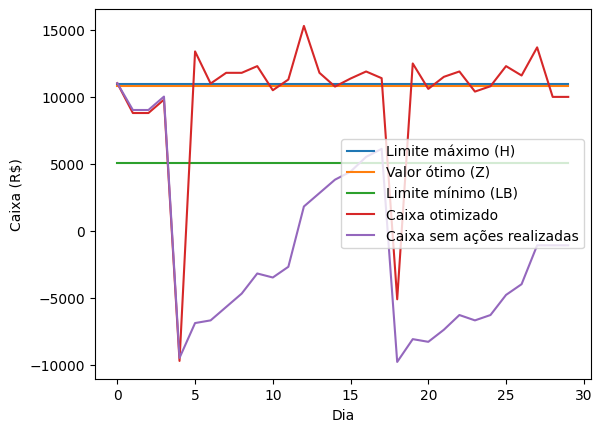

In [9]:
plt.plot([h] * params.N_DIAS, label="Limite máximo (H)")
plt.plot([z] * params.N_DIAS, label="Valor ótimo (Z)")
plt.plot([lb] * params.N_DIAS, label="Limite mínimo (LB)")
plt.plot(valores_diarios_otimizados, label="Caixa otimizado")
plt.plot(valores_diarios_padrao, label="Caixa sem ações realizadas")
plt.legend(loc='center right')
plt.xlabel("Dia")
plt.ylabel("Caixa (R$)")
plt.show()